In [1]:
# from leecarter import leecarter
import pandas as pd
from tqdm import tqdm
import numpy.matlib

import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
Image_width = 10
plt.rc('text', usetex = True) # latex ticks
plt.rc('text.latex')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern'],
})

EXTRA_SMALL = 10
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
filename = 'death_rates2.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1958,0,-2.723920,-2.480397,-2.591788
1,1958,1,-5.352562,-5.291540,-5.320972
2,1958,2,-6.357324,-6.197751,-6.272237
3,1958,3,-6.732962,-6.527266,-6.622576
4,1958,4,-7.066751,-6.837297,-6.943382
...,...,...,...,...,...
6867,2019,96,-1.240243,-1.143835,-1.220129
6868,2019,97,-1.123130,-1.046502,-1.108135
6869,2019,98,-1.127061,-0.963167,-1.093425
6870,2019,99,-0.980088,-0.864780,-0.957410


In [4]:
age = 65
column = 'Female_l'

# Linear model

In [5]:
fm = mortality.pivot(index="Age", columns="Year", values=column)
data = fm.values # (101 (age), 62 (years))

total_years = data.shape[1]
trained_from = 30
trained_to = 41
trained_data = data[:,trained_from:trained_to+1]
trained_time = np.arange(trained_from, trained_to + 1)


b1 = ((trained_time[None,:] - trained_time.mean())*(trained_data-trained_data.mean(1)[:,None])).sum(1)/((trained_time - trained_time.mean())**2).sum()
b0 = trained_data.mean(1)-b1*trained_time.mean()

b1 = b1[:, None] 
b0 = b0[:, None]


estimated_time = np.arange(trained_to + 1, total_years + 1)
estimated_data_without_rw = np.exp(b1*estimated_time[None,:] + b0)

adjusted_trend = b1*trained_time[None,:] + b0

# Linear model in rolling window scheme

In [6]:
W_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]

total_years = data.shape[1]
estimated_from = 42
lag = 1

estimated_data_different_windows = []
for window_size in W_lengths:

    estimated_data = []

    for i in range(total_years - estimated_from + 1):
        trained_to = estimated_from + i 
        trained_from = trained_to - window_size 
        trained_data = data[:,trained_from:trained_to]
        trained_time = np.arange(trained_from, trained_to)

        b1 = ((trained_time[None,:] - trained_time.mean())*(trained_data-trained_data.mean(1)[:,None])).sum(1)/((trained_time - trained_time.mean())**2).sum()
        b0 = trained_data.mean(1)-b1*trained_time.mean()

        estimated_data.append(trained_to*b1 + b0)

    estimated_data = np.array(estimated_data).T
    estimated_data_different_windows.append(estimated_data)

estimated_data_different_windows = np.array(estimated_data_different_windows) # shape (7 (windows number), 101 (age), 23 (years))

estimated_data_with_rw = np.exp(estimated_data_different_windows.mean(0))

# Lee-Carter for a given age

### Lee-Carter model implementation: ARIMA usage, training window from 1958 to 1999

In [7]:
def fit_arima(matrix):
    d = []
    for a in range(5):
        for b in range(5):
            for c in range(5):
                mod = ARIMA(matrix, order=(a,b,c))
                res = mod.fit()
                d.append([res.llf, a, b, c])

    return max(d)


def predict(matrix, column: str = 'Female_l', age = 65, steps=21, training_start = 0):
    """_summary_

    Args:
        matrix (_type_): _description_
        column (str, optional): _description_. Defaults to 'Female_l'.
        age (int, optional): _description_. Defaults to 65.
        steps (int, optional): _description_. Defaults to 21.
        training_start (int, optional): below 20 there are problems with ARIMA convergence. Defaults to 20.

    Returns:
        _type_: _description_
    """    
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,training_start:round(np.shape(fm)[1]*2/3)]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    _, par1, par2, par3 = fit_arima(k_t)
    print((par1,par2,par3))
    mod = ARIMA(k_t, order=(par1,par2,par3))
    res = mod.fit()

    pred = res.forecast(steps=steps)
    return np.exp(a_x[age] + b_x[age]*pred)

def predict_no_arima(matrix, column: str='Female_l', age=65, steps=21, training_start = 30):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,training_start:round(np.shape(fm)[1]*2/3)]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    theta = (k_t[-1] - k_t[0]) / (len(k_t) - 1) # according to the Girosi, King, 2007 and Lee Carter done it the same way. ARIMA was exploding

    pred = k_t[-1] + theta * np.arange(1, steps + 1)

    return np.exp(a_x[age] + b_x[age]*pred)

In [8]:
vals = predict(mortality, column, age)
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))

(4, 2, 3)


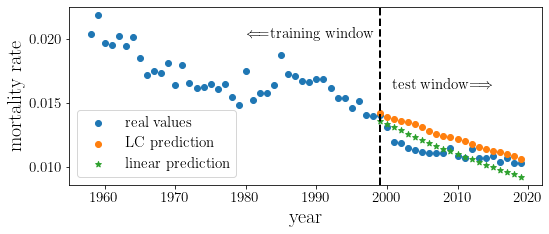

In [9]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.35 * Image_width))
ax.scatter(real_vals['Year'], real_vals[column], label='real values')
ax.scatter(np.arange(1999,2020,1), vals, label='LC prediction')
ax.set_xlabel('year')
ax.set_ylabel('mortality rate')
# ax.set_title("Lee--Carter model long term forecasts")
ax.axvline(x = 1999, color = 'black', linestyle = '--', linewidth = 2)
if age == 65 and column == 'Female_l':
    ax.text(1980, 0.02, '$\Longleftarrow$training window', horizontalalignment='left')
    ax.text(2015, 0.016, 'test window$\Longrightarrow$', horizontalalignment='right')
ax.scatter(np.arange(1999,2020,1), estimated_data_without_rw[age, :], marker = '*', label='linear prediction')
ax.legend()
fig.tight_layout()

plt.savefig(f'Figures/Mortality_rate_21_years_ahead_ARIMA_forecast_{column}_{age}.jpg', bbox_inches = 'tight', dpi = 700)

### Lee-Carter model implementation: ARIMA usage, averages over different training windows

In [10]:
# W_lengths = [21, 30, 41] # we cannot technically take less than 21
# Vals = np.ones((len(W_lengths), 21))
# for i, w_len in enumerate(W_lengths):
#     Vals[i, :] = predict(mortality, column, age, training_start = 41 - w_len)
# vals = np.mean(Vals, 0)
# real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
# real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))

In [11]:
# fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.4 * Image_width))
# ax.scatter(real_vals['Year'], real_vals[column], label='real values')
# ax.scatter(np.arange(1999,2020,1), vals, label='LC prediction')
# ax.set_xlabel('year')
# ax.set_ylabel('mortality rate')
# # ax.set_title("Lee--Carter model long term forecasts")
# ax.axvline(x = 1999, color = 'black', linestyle = '--', linewidth = 2)
# if age == 65 and column == 'Female_1':
#     ax.text(1980, 0.02, '$\Longleftarrow$training window', horizontalalignment='left')
#     ax.text(2015, 0.016, 'test window$\Longrightarrow$', horizontalalignment='right')
# ax.scatter(np.arange(1999,2020,1), estimated_data_without_rw[age, :], marker = '*', label='linear prediction')
# ax.legend()
# fig.tight_layout()

# plt.savefig(f'Figures/Mortality_rate_21_years_ahead_ARIMA_forecast_averaged_{column}_{age}.jpg', bbox_inches = 'tight', dpi = 700)

### Lee-Carter model implementation: drift usage, averages over different training windows

In [12]:
W_lengths = [41, 10]
Vals = np.ones((len(W_lengths), 21))
for i, w_len in enumerate(W_lengths):
    Vals[i, :] = predict_no_arima(mortality, column, age, training_start = 41 - w_len)
vals = np.mean(Vals, 0)
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))

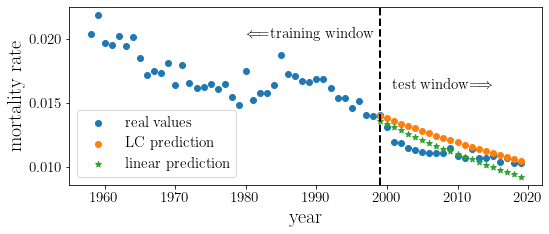

In [13]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.35 * Image_width))
ax.scatter(real_vals['Year'], real_vals[column], label='real values')
ax.scatter(np.arange(1999,2020,1), vals, label='LC prediction')
ax.set_xlabel('year')
ax.set_ylabel('mortality rate')
# ax.set_title("Lee--Carter model long term forecasts")
ax.axvline(x = 1999, color = 'black', linestyle = '--', linewidth = 2)
if age == 65 and column == 'Female_l':
    ax.text(1980, 0.02, '$\Longleftarrow$training window', horizontalalignment='left')
    ax.text(2015, 0.016, 'test window$\Longrightarrow$', horizontalalignment='right')
ax.scatter(np.arange(1999,2020,1), estimated_data_without_rw[age, :], marker = '*', label='linear prediction')
ax.legend()
fig.tight_layout()

plt.savefig(f'Figures/Mortality_rate_21_years_ahead_drift_forecast_averaged_{column}_{age}.jpg', bbox_inches = 'tight', dpi = 700)

# Lee-Carter implementation in a rolling window scheme

In [14]:
def predict_rolling(fm_train, age):
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    theta = (k_t[-1] - k_t[0]) / (len(k_t) - 1) # according to the Girosi, King, 2007 and Lee Carter done it the same way. ARIMA was exploding

    pred = k_t[-1] + theta
    return np.exp(a_x[age] + b_x[age]*pred)

def rolling_window(matrix, column: str = 'Female_l', age = 65, start_of_test = 53, end_of_test = 62, window_length = 41):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    rolling_window_forecasts = np.ones(end_of_test - start_of_test)*-999
    for i in tqdm(range(start_of_test, end_of_test)):
        fm_train = fm.iloc[:, i - window_length:i]
        rolling_window_forecasts[i - start_of_test] = predict_rolling(fm_train, age = age)
    return rolling_window_forecasts
    

In [15]:
# averaging of forecasts
W_lengths = [3, 4, 5, 6, 7, 8, 20, 41]
Vals = np.ones((len(W_lengths), 21))
for i, w_len in enumerate(W_lengths):
    Vals[i, :] = rolling_window(mortality, column, age, start_of_test = 41, window_length = w_len)
vals = np.mean(Vals, 0)

100%|██████████| 21/21 [00:00<00:00, 569.07it/s]


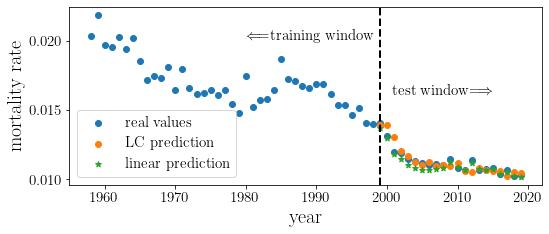

In [16]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.35 * Image_width))
ax.scatter(real_vals['Year'], real_vals[column], label='real values')
ax.scatter(np.arange(1999,2020,1), vals, label='LC prediction')
ax.set_xlabel('year')
ax.set_ylabel('mortality rate')
# ax.set_title("Lee--Carter model short term forecasts")
ax.axvline(x = 1999, color = 'black', linestyle = '--', linewidth = 2)
if age == 65 and column == 'Female_l':
    ax.text(1980, 0.02, '$\Longleftarrow$training window', horizontalalignment='left')
    ax.text(2015, 0.016, 'test window$\Longrightarrow$', horizontalalignment='right')
ax.scatter(np.arange(1999,2020,1), estimated_data_with_rw[age, :], marker = '*', label='linear prediction')
ax.legend()
fig.tight_layout()

plt.savefig(f'Figures/Mortality_rate_1_year_ahead_forecast_{column}_{age}.jpg', bbox_inches = 'tight', dpi = 700)

In [17]:
MAE_Lee_Carter = np.mean(np.abs(vals - real_vals[column].to_numpy()[-21:]))
MAE_Lee_Carter

0.0002970607748732406

In [18]:
MAE_linear = np.mean(np.abs(estimated_data_with_rw[age, :] - real_vals[column].to_numpy()[-21:]))
MAE_linear

0.00020760066691406142